#### Создаем  и активируем виртуальное окружение 

In [ ]:
# !python3 -m venv venv

# !source venv/bin/activate

#### Импортируем бибилотеки

In [11]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#### Поключаем MLflow для логирования экспов 

In [12]:
mlflow.sklearn.autolog()

#### Функция для вывода MLflow UI в виде страницы браузера

In [89]:
import subprocess
import webbrowser


def start_mlflow_ui(port=5000, backend_store_uri=None):
    """
    Запускает MLflow UI и открывает браузер
    
    Parameters:
    port: порт для запуска UI
    backend_store_uri: URI для бэкенда хранения (например, "file:///./mlruns")
    artifact_root: корневая директория для артефактов
    """
    command = ["mlflow", "ui", "--port", str(port)]
    
    if backend_store_uri:
        command.extend(["--backend-store-uri", backend_store_uri])
    
    
    # Запускаем процесс
    process = subprocess.Popen(command)

    
    # Открываем браузер
    webbrowser.open(f"http://localhost:{port}")
    
    return process


# # Запуск с настройками по умолчанию
# ui_process = start_mlflow_ui(backend_store_uri="file:///./mlruns")

# try:
#     # Держим процесс активным
#     ui_process.wait()
# except KeyboardInterrupt:
#     print("Остановка MLflow UI...")
#     ui_process.terminate()

#### Загружаем датасет

In [14]:
df = pd.read_csv('podcasts.csv')

In [15]:
df.head(2)

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3,Positive,55.158695
1,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1,Neutral,7.686559


In [32]:
#Смотрим размерность датасета
df.shape

(52500, 11)

In [33]:
#выводим основные стат.показатели датасета. 
df.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,47254.000000,52500.000000,47242.000000,52500.000000,47105.000000
mean,62.853491,60.163949,50.053434,1.497962,45.560293
std,33.137428,23.158567,28.884997,1.117412,27.182454
min,5.000000,20.000000,0.010000,0.000000,0.000000
25%,34.300000,40.000000,25.030000,0.000000,23.286442
50%,62.870000,60.300000,50.035000,1.000000,43.555490
75%,91.550000,80.310000,75.100000,2.000000,64.953793
max,120.000000,100.000000,100.000000,3.000000,119.970000


Все представленные фичи, а также целевой таргет имеют сопоставимый мастшаб распределения данных
Значит препроцессинг связанный масштабированием нам не нужен будет в дальнейшем

In [87]:
#валидируем датасет на пропуски и удаляем если их доля на тотале не превышает 15%
print(f"Пропуски в данных \n{df.isna().sum()}")
print('======================')

def check_null(df):
    view_null = np.round(df.isna().sum().max()/df.shape[0] * 100)
    if view_null < 15:
        print(f"Доля {np.round(df.isna().sum().max()/df.shape[0] * 100)}% пропусков")
        if df.dropna().shape[0] < df.shape[0]*0.85:
             print('НО доля пропусков на тотале сильно больше 15%. Будем заполнять пропуски')
             return df
        else:
            print('Lоля пропусков на тотале меньше  20%. Удаляем пропуски')
            return df.dropna()
    else:
        print('Меньше 20%')
        return df

df = check_null(df)

Пропуски в данных 
Podcast_Name                      0
Episode_Title                     0
Episode_Length_minutes         5246
Genre                             0
Host_Popularity_percentage        0
Publication_Day                   0
Publication_Time                  0
Guest_Popularity_percentage    5258
Number_of_Ads                     0
Episode_Sentiment                 0
Listening_Time_minutes         5395
dtype: int64
Доля 10.0% пропусков
НО доля пропусков на тотале сильно больше 15%. Будем заполнять пропуски


In [91]:
#Смотрим на наличие дубликатов в данных

df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
52495     True
52496     True
52497     True
52498     True
52499     True
Length: 52500, dtype: bool

In [ ]:
#Выборка одной пару дубликатов
df[(df['Podcast_Name'] == 'Business Briefs')& (df['Episode_Title'] == "Episode 85") & (df['Listening_Time_minutes'] == 17.220998)]

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
8484,Business Briefs,Episode 85,NaN,Business,41.47,Wednesday,Afternoon,33.58,0,Neutral,17.220998
52498,Business Briefs,Episode 85,NaN,Business,41.47,Wednesday,Afternoon,33.58,0,Neutral,17.220998


Т.к. у нас датасет представляет собой агрегированную информацию по прослушиваниям подкастов, то велика вероятность того, что были пользователя прослушавшие одинаковое кол-во времени. 
На данном этапе пока дубликаты оставляем

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Podcast_Name                 52500 non-null  object 
 1   Episode_Title                52500 non-null  object 
 2   Episode_Length_minutes       47254 non-null  float64
 3   Genre                        52500 non-null  object 
 4   Host_Popularity_percentage   52500 non-null  float64
 5   Publication_Day              52500 non-null  object 
 6   Publication_Time             52500 non-null  object 
 7   Guest_Popularity_percentage  47242 non-null  float64
 8   Number_of_Ads                52500 non-null  int64  
 9   Episode_Sentiment            52500 non-null  object 
 10  Listening_Time_minutes       47105 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 4.4+ MB


In [191]:
numeric_features_columns = df.select_dtypes(np.number).columns
cat_features_columns = df.select_dtypes(object).columns
target_column = 'Listening_Time_minutes'

In [140]:
def looking_into_numeric_features(data, num_col):
    
    n_cols = 3
    n_rows = (len(numeric_features_columns) + n_cols) // 3
    plt.figure(figsize=(18,10))
    
    for i, feature in enumerate(numeric_features_columns):
        plt.subplot(n_rows, n_cols, i+1)
        sns.kdeplot(data, x=feature)
        plt.xlabel(feature)
        plt.ylabel("Плотность")
        plt.title("Распределение основны кол-ых фичей")        

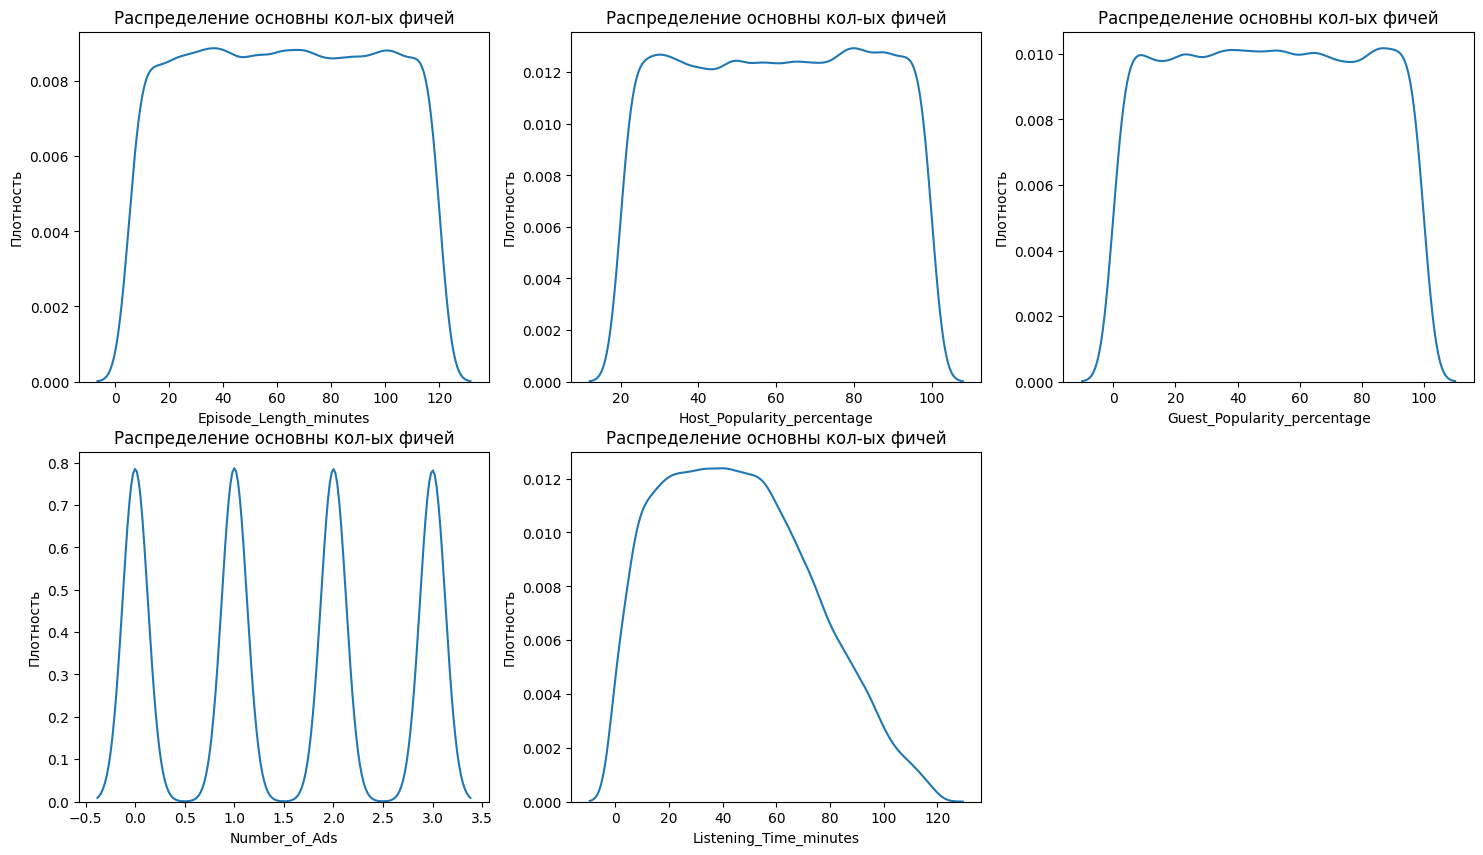

In [141]:
looking_into_numeric_features(df, numeric_features_columns)

Видим, что плотность распределений везде практически идентична.

Во времени прослушивания видим, смещение распределения влево т.е. большая часть прослушиваний подкастов пользователями краткосрочна т.к. длина подкастов по времени у нас в целом распределено равномерно. 



In [181]:
#Построим графики для определения существующих зависимостей основных независимых признаков с целевым таргетом
def plots_correlation_numeric_features_with_target(data, num_col):
    num_col = num_col.to_list()
    num_col.remove('Listening_Time_minutes')
    target = 'Listening_Time_minutes'
    n_cols = 3
    n_rows = (len(num_col) + n_cols) // 3
    plt.figure(figsize=(18,10))
    
    for i, feature in enumerate(num_col):
        plt.subplot(n_rows, n_cols, i+1)
        plt.plot(data[feature], data[target])
        plt.xlabel(feature)
        plt.ylabel("Время прослушивания")
        plt.title(f"Зависимость {target} от {feature}")        

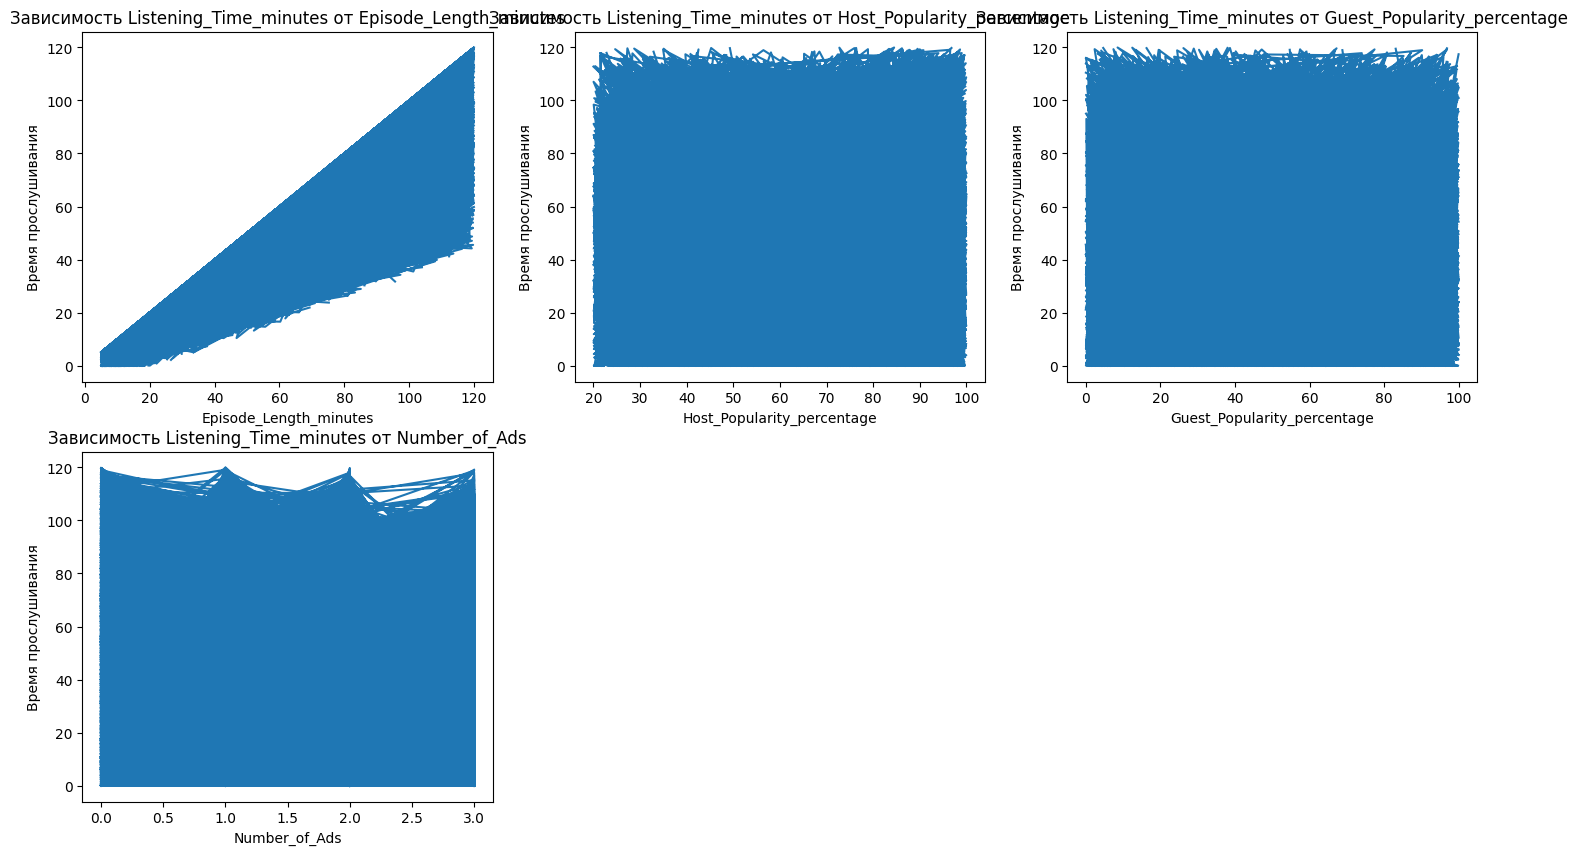

In [180]:
plots_correlation_numeric_features_with_target(data=df, num_col=numeric_features_columns)

С целевым таргетом коррелирует продолжительность подкаста. Рассмотрим на сколько сильна эта связь

<Axes: >

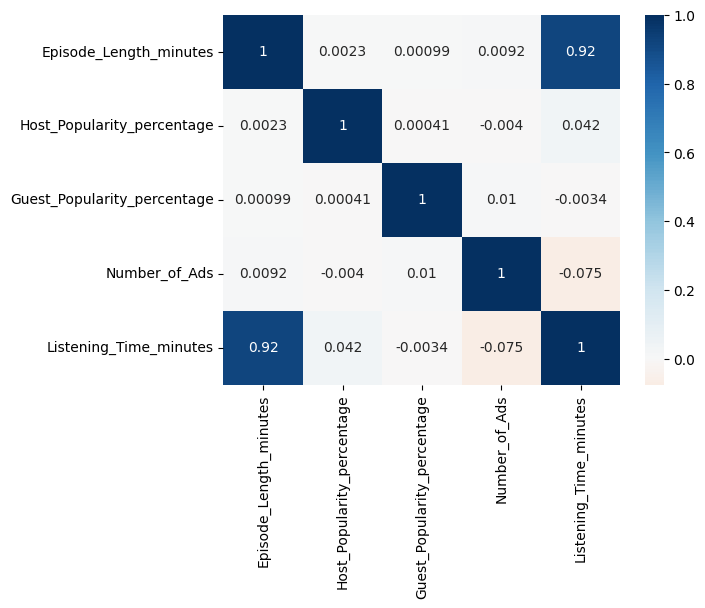

In [189]:
#Строим корреляционную темпловую карту

sns.heatmap(data=df[numeric_features_columns].corr(method='spearman'), annot=True, cmap='RdBu', center=0)

Наблюдаем сильную корреляцию таргета с длительностью подкаста = 0.92. 

Мультиколлинеарность независимых признаков около нулевая. 

Рассмотрим распределение категориальных фичей 

In [224]:
def categorial_feat_boxplots(data, cat_feat, target):
    plt.figure(figsize=(40,30))
    num_col = 3
    n_rows = len(cat_feat) // 3 + 1
    for ind, feature in enumerate(cat_feat):
        plt.subplot(n_rows, num_col, ind +1)
        sns.boxplot(data, x=feature)
        plt.xlabel(feature)
        plt.xticks(rotation=45)
       
        plt.title(feature)
    plt.show()
    

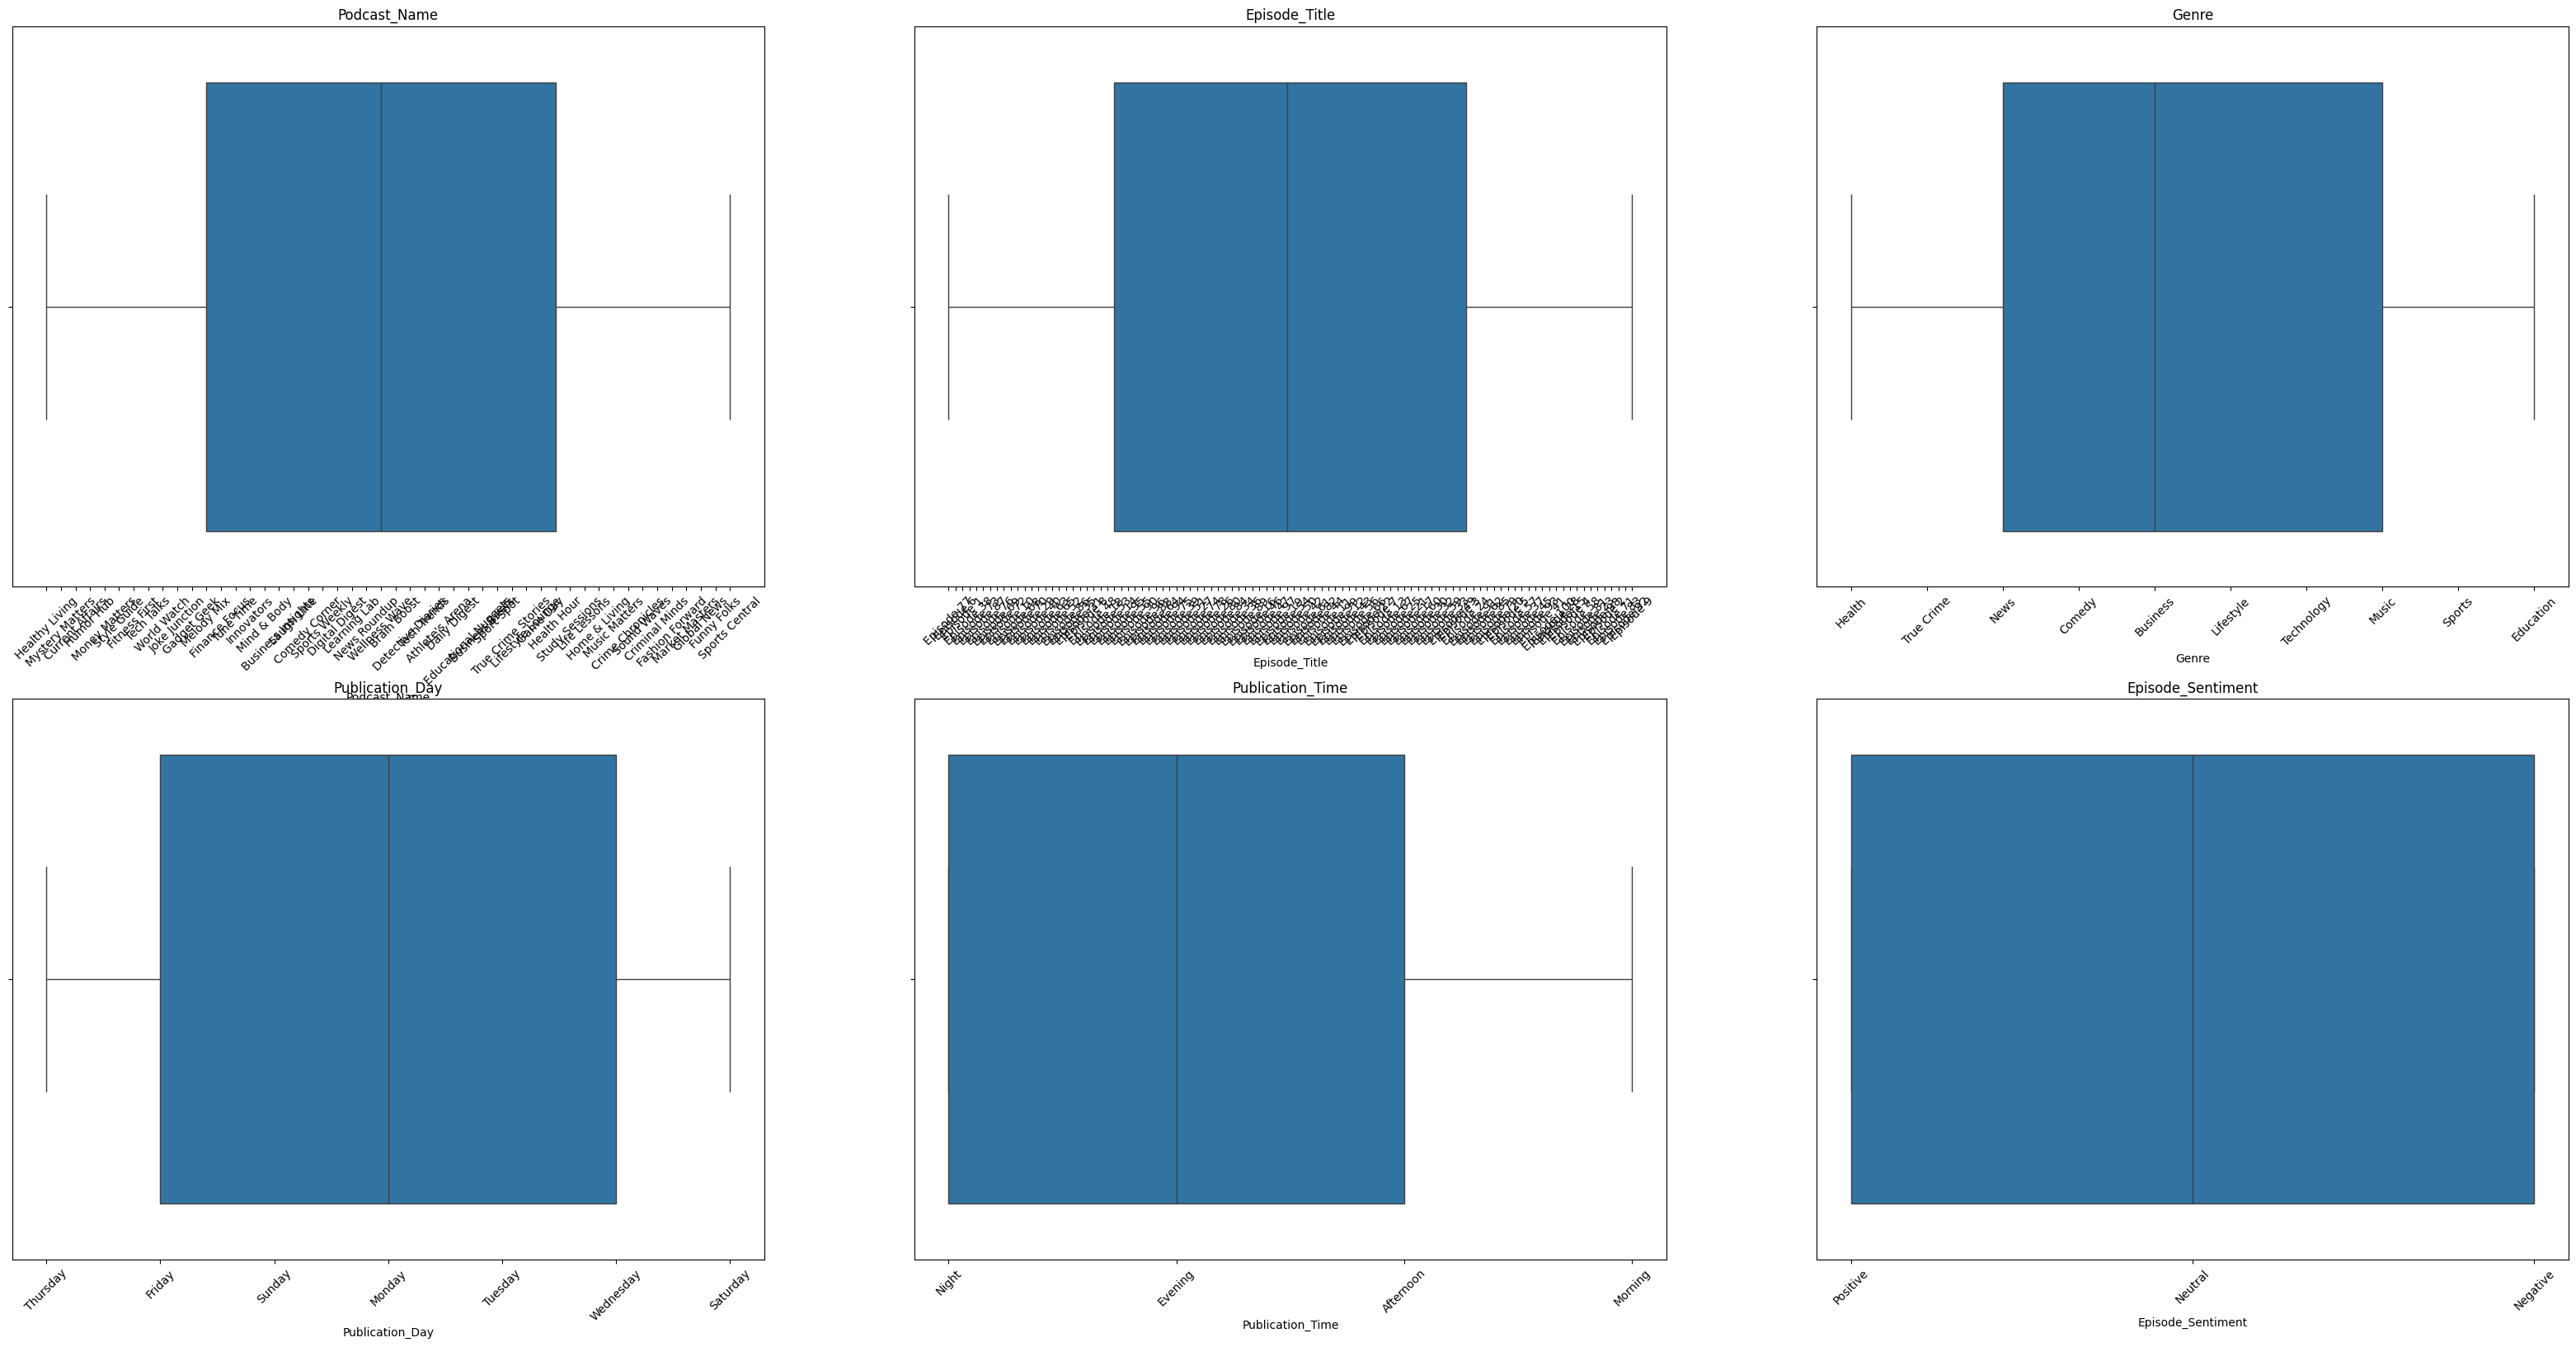

In [225]:
categorial_feat_boxplots(data=df, cat_feat=cat_features_columns, target=target_column)

In [229]:
!git add .